In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import LSTM, GRU, Dense, Dropout, ConvLSTM2D, Flatten, Input, Attention, Reshape, Permute, Multiply
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [3]:

file_path = "events.csv"
df = pd.read_csv("events.csv")
print(df.info())
print(df.head())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52966 entries, 0 to 52965
Data columns (total 5 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Start time UTC                      52966 non-null  object 
 1   End time UTC                        52966 non-null  object 
 2   Start time UTC+03:00                52966 non-null  object 
 3   End time UTC+03:00                  52966 non-null  object 
 4   Electricity consumption in Finland  52966 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.0+ MB
None
        Start time UTC         End time UTC Start time UTC+03:00  \
0  2015-12-31 21:00:00  2015-12-31 22:00:00  2016-01-01 00:00:00   
1  2015-12-31 22:00:00  2015-12-31 23:00:00  2016-01-01 01:00:00   
2  2015-12-31 23:00:00  2016-01-01 00:00:00  2016-01-01 02:00:00   
3  2016-01-01 00:00:00  2016-01-01 01:00:00  2016-01-01 03:00:00   
4  2016-01-01 01:00:00  2016-01-01 02:00

In [4]:

df['Start time UTC'] = pd.to_datetime(df['Start time UTC'])
df.set_index('Start time UTC', inplace=True)
df.interpolate(method='linear', inplace=True)
df = df[~df.index.duplicated(keep='first')]

/var/folders/4q/tppj85sn47b0s1vxvzn76k700000gn/T/ipykernel_22792/181166133.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


In [5]:

df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Month'] = df.index.month
df['Weekday'] = df.index.weekday

def get_season(month):
    if month in [12, 1, 2]: return 0
    elif month in [3, 4, 5]: return 1
    elif month in [6, 7, 8]: return 2
    else: return 3

df['Season'] = df['Month'].apply(get_season)
df['Lag_1'] = df['Electricity consumption in Finland'].shift(1)
df['Lag_24'] = df['Electricity consumption in Finland'].shift(24)
df.fillna(method='bfill', inplace=True)

/var/folders/4q/tppj85sn47b0s1vxvzn76k700000gn/T/ipykernel_22792/558344481.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [ ]:

features = ['Electricity consumption in Finland', 'Hour', 'Day', 'Month', 'Weekday', 'Season', 'Lag_1', 'Lag_24']
df = df[features]
print(df.head())

                     Electricity consumption in Finland  Hour  Day  Month  \
Start time UTC                                                              
2015-12-31 21:00:00                             10800.0    21   31     12   
2015-12-31 22:00:00                             10431.0    22   31     12   
2015-12-31 23:00:00                             10005.0    23   31     12   
2016-01-01 00:00:00                              9722.0     0    1      1   
2016-01-01 01:00:00                              9599.0     1    1      1   

                     Weekday  Season    Lag_1   Lag_24  
Start time UTC                                          
2015-12-31 21:00:00        3       0  10800.0  10800.0  
2015-12-31 22:00:00        3       0  10800.0  10800.0  
2015-12-31 23:00:00        3       0  10431.0  10800.0  
2016-01-01 00:00:00        4       0  10005.0  10800.0  
2016-01-01 01:00:00        4       0   9722.0  10800.0  


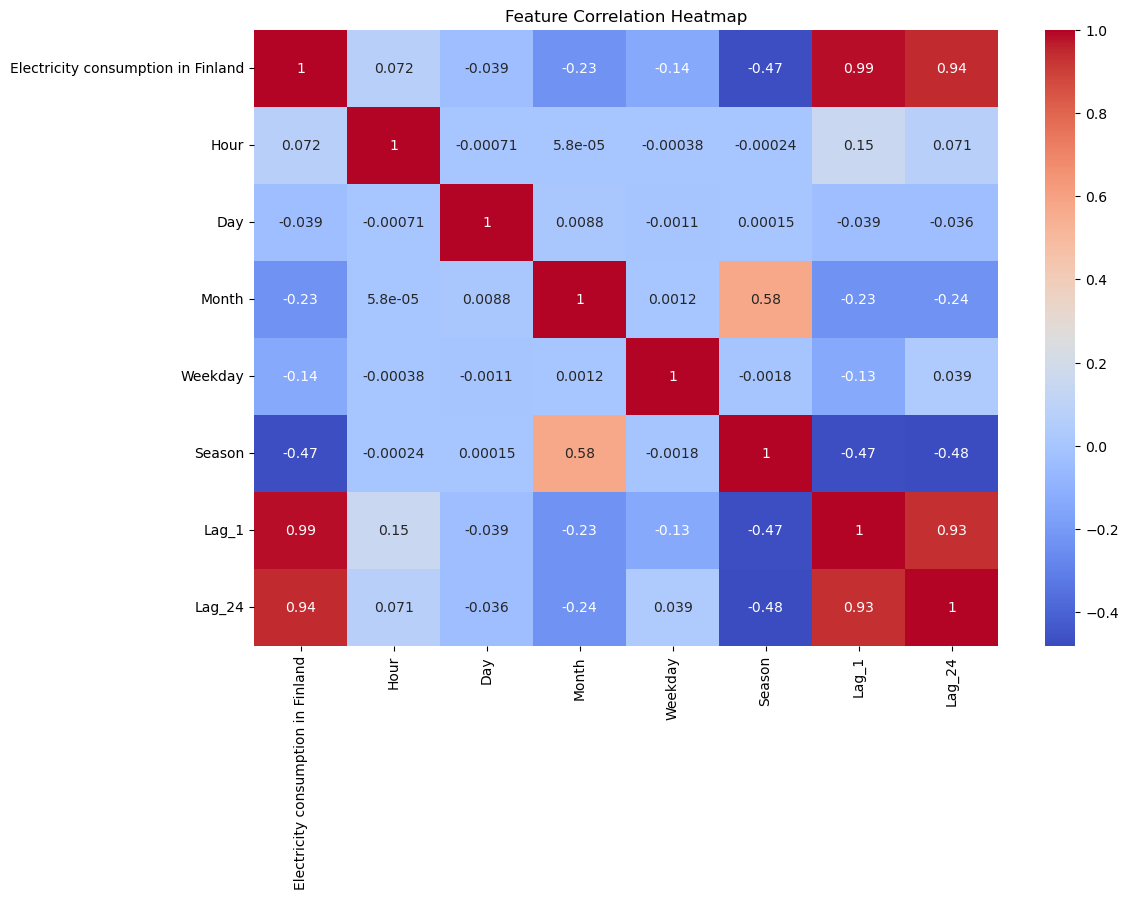

In [7]:

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [9]:

def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step)])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, Bidirectional, Multiply, Permute,
    Reshape, Softmax, Lambda, RepeatVector
)


time_step = 60  
feature_count = X_train.shape[2]  


inputs = Input(shape=(time_step, feature_count))


x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
x = Dropout(0.2)(x)


attention = Dense(1, activation='tanh')(x)  
attention = Softmax(axis=1)(attention)  


attention = Multiply()([x, attention])  


x = Bidirectional(LSTM(64, return_sequences=False))(attention)
x = Dropout(0.2)(x)


x = Dense(50, activation='relu')(x)
output = Dense(1)(x)


model = Model(inputs, output)
model.compile(optimizer='adam', loss='mean_squared_error')


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 60, 256)   │    140,288 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 60, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 60, 1)     │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 60, 1)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 60, 256)   │          0 │ dropout[0][0],    │
│                     │                   │            │ softmax[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ multiply[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50)        │      6,450 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         51 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 311,398 (1.19 MB)

 Trainable params: 311,398 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

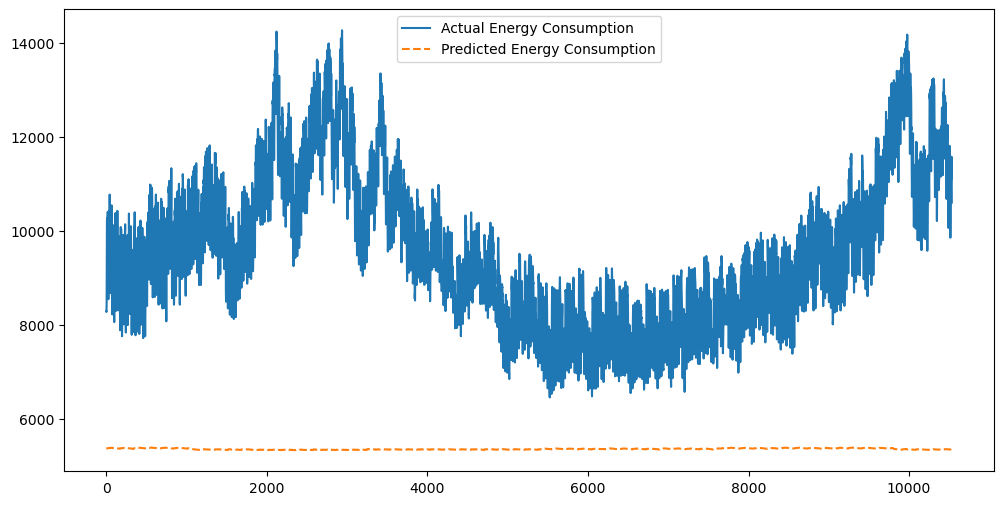

In [ ]:

num_features = scaler.min_.shape[0]  


y_test_reshaped = y_test.reshape(-1, 1)
y_pred_reshaped = y_pred.reshape(-1, 1)

dummy_features = np.zeros((y_test.shape[0], num_features - 1))  


y_test_scaled_back = np.hstack([dummy_features, y_test_reshaped])  
y_pred_scaled_back = np.hstack([dummy_features, y_pred_reshaped])  


y_test_rescaled = scaler.inverse_transform(y_test_scaled_back)[:, -1]
y_pred_rescaled = scaler.inverse_transform(y_pred_scaled_back)[:, -1]


plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Energy Consumption")
plt.plot(y_pred_rescaled, label="Predicted Energy Consumption", linestyle="dashed")
plt.legend()
plt.show()

330/330 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


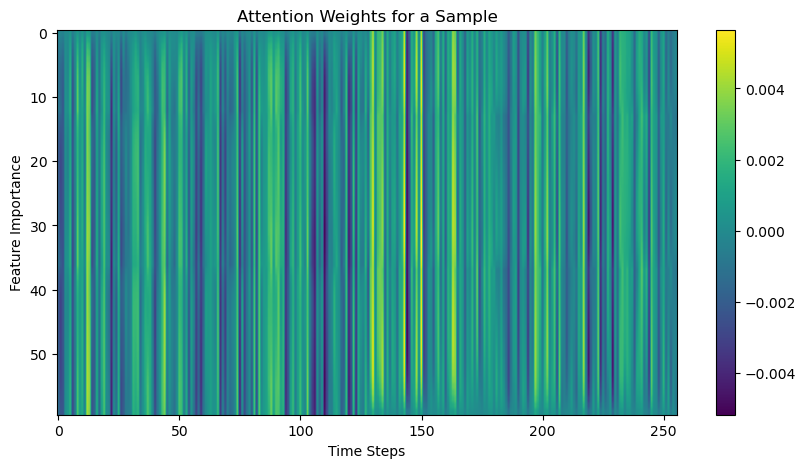

In [ ]:

attention_model = tf.keras.Model(inputs=model.input, outputs=attention)   
attention_weights = attention_model.predict(X_test)  


plt.figure(figsize=(10, 5))
plt.imshow(attention_weights[0], cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Attention Weights for a Sample")
plt.xlabel("Time Steps")
plt.ylabel("Feature Importance")
plt.show()

In [ ]:

output_layer = Dense(24)(x)  

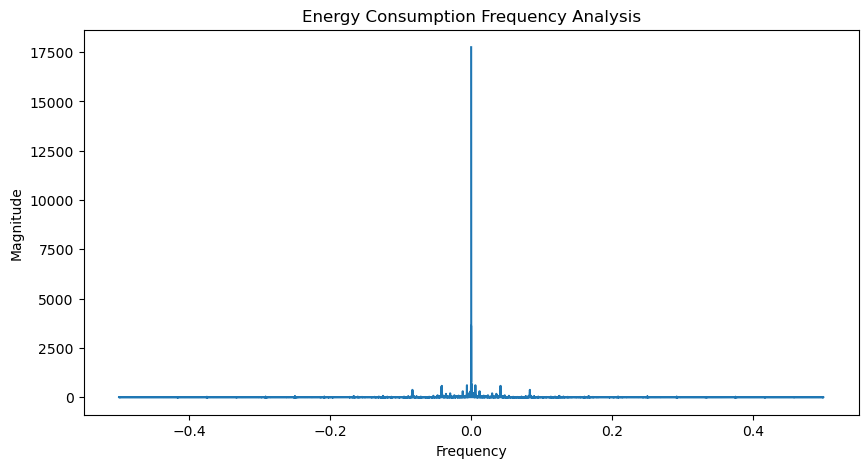

In [ ]:
from scipy.fftpack import fft

fft_values = fft(y_train)  # Apply FFT on training labels
frequencies = np.fft.fftfreq(len(fft_values))

plt.figure(figsize=(10, 5))
plt.plot(frequencies, np.abs(fft_values))  # Plot frequency vs magnitude
plt.title("Energy Consumption Frequency Analysis")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

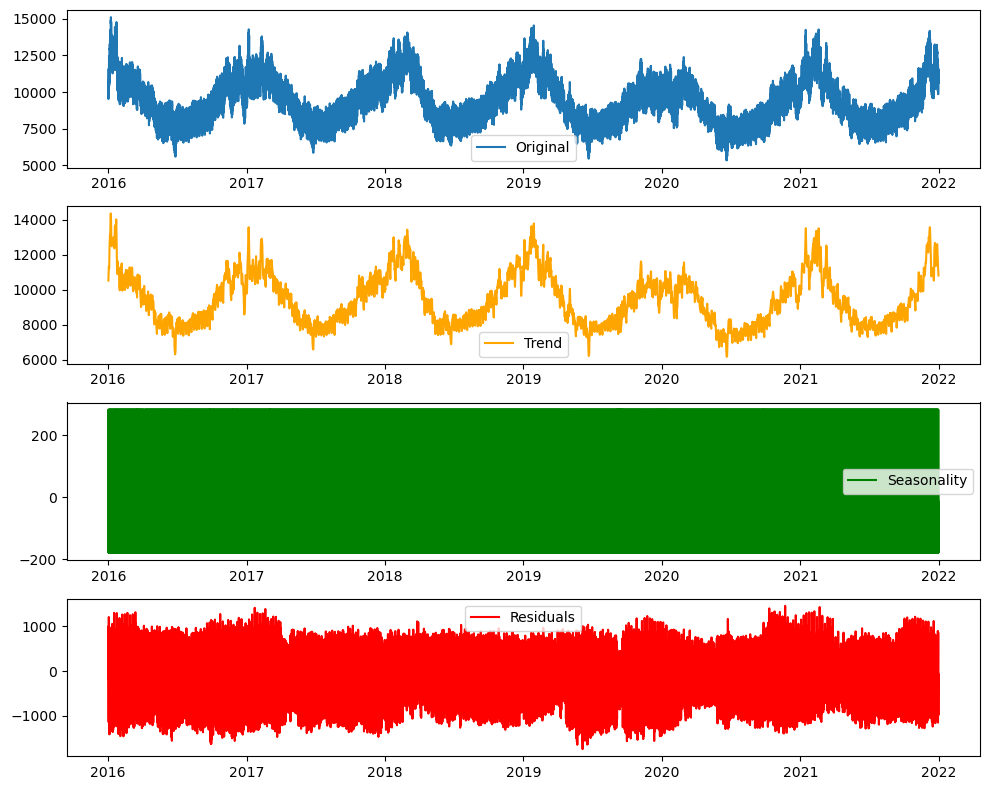

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


decomposition = seasonal_decompose(df['Electricity consumption in Finland'], period=24, model='additive')


plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(df['Electricity consumption in Finland'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
print("y_pred exists:", 'y_pred' in locals())  # Check if y_pred is defined
print("y_pred shape:", y_pred.shape if 'y_pred' in locals() else "Not Defined")

y_pred exists: False
y_pred shape: Not Defined


In [15]:
print("Model trained:", 'model' in locals())

Model trained: True


In [16]:
print("X_test shape:", X_test.shape if 'X_test' in locals() else "Not Defined")
print("NaN values in X_test:", np.isnan(X_test).sum())

X_test shape: (10533, 60, 8)
NaN values in X_test: 0


In [17]:
y_pred = model.predict(X_test)
print("First 5 predictions:", y_pred[:5])

330/330 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step
First 5 predictions: [[0.00172025]
 [0.0016976 ]
 [0.00178127]
 [0.00185434]
 [0.00187642]]


In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 60, 256)   │    140,288 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 60, 256)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 60, 1)     │        257 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 60, 1)     │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 60, 256)   │          0 │ dropout[0][0],    │
│                     │                   │            │ softmax[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ multiply[0][0]    │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50)        │      6,450 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         51 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 311,398 (1.19 MB)

 Trainable params: 311,398 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
y_pred = model.predict(X_test)
print("First 5 predictions:", y_pred[:5])

330/330 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step
First 5 predictions: [[0.00172025]
 [0.0016976 ]
 [0.00178127]
 [0.00185434]
 [0.00187642]]


In [21]:
print(y_pred[:10])  # Print first 10 predictions

[[0.00172025]
 [0.0016976 ]
 [0.00178127]
 [0.00185434]
 [0.00187642]
 [0.0018973 ]
 [0.00192012]
 [0.00194589]
 [0.00196665]
 [0.00198165]]


In [22]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)

X_test shape: (10533, 60, 8)
y_test shape: (10533,)
y_pred shape: (10533, 1)


In [24]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)
print(history.history['loss'])


Epoch 1/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 74s 112ms/step - loss: 0.0022
Epoch 2/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 76s 114ms/step - loss: 9.9557e-04
Epoch 3/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 76s 115ms/step - loss: 7.0772e-04
Epoch 4/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 80s 121ms/step - loss: 5.6379e-04
Epoch 5/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 88s 133ms/step - loss: 4.9225e-04
Epoch 6/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 77s 116ms/step - loss: 4.2805e-04
Epoch 7/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 74s 111ms/step - loss: 4.0137e-04
Epoch 8/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 74s 112ms/step - loss: 3.6532e-04
Epoch 9/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 73s 110ms/step - loss: 3.4021e-04
Epoch 10/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 77s 116ms/step - loss: 3.6294e-04
[0.0017202763119712472, 0.0009109257371164858, 0.0006568278768099844, 0.0005359791102819145, 0.0004654343065340072, 0.0004232502542436123, 0.000390950299333781, 0.00037031533429399133, 0.00034279839019291103, 0.0003367579774931073]


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root MSE
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Mean Absolute Percentage Error
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R² Score:", r2)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE: 0.4449355176869106
MSE: 0.22398259641377954
RMSE: 0.47326799639715716
MAPE: 99.8167440468647
R² Score: -7.633119966189415


In [28]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 105s 80ms/step - loss: 3.8121e-04 - val_loss: 2.7313e-04
Epoch 2/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 105s 80ms/step - loss: 3.3794e-04 - val_loss: 2.5949e-04
Epoch 3/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 108s 82ms/step - loss: 3.1614e-04 - val_loss: 4.5560e-04
Epoch 4/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 109s 82ms/step - loss: 3.1070e-04 - val_loss: 2.1474e-04
Epoch 5/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 108s 82ms/step - loss: 2.6260e-04 - val_loss: 1.8211e-04
Epoch 6/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 106s 80ms/step - loss: 2.5254e-04 - val_loss: 5.9375e-04
Epoch 7/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 106s 80ms/step - loss: 2.5640e-04 - val_loss: 1.9511e-04
Epoch 8/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 104s 79ms/step - loss: 2.3635e-04 - val_loss: 1.5377e-04
Epoch 9/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 109s 83ms/step - loss: 2.2473e-04 - val_loss: 1.4552e-04
Epoch 10/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 107s 81ms/step - loss: 2.0814e-04 - val_loss: 1.4470e-04


In [29]:
train_accuracies = history.history.get('accuracy', history.history.get('loss'))  # Use 'accuracy' if available, else 'loss'
mean_accuracy = np.mean(train_accuracies)
std_dev_accuracy = np.std(train_accuracies)

print(f"Mean Training Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Training Accuracy: {std_dev_accuracy:.4f}")

Mean Training Accuracy: 0.0003
Standard Deviation of Training Accuracy: 0.0001


In [30]:
import time

start_time = time.time()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=1)
end_time = time.time()

cpu_time = end_time - start_time
print(f"Mean CPU Time for {10} epochs: {cpu_time:.2f} seconds")

Epoch 1/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 107s 81ms/step - loss: 1.9524e-04 - val_loss: 1.9742e-04
Epoch 2/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 112s 84ms/step - loss: 1.9209e-04 - val_loss: 1.9939e-04
Epoch 3/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 103s 78ms/step - loss: 1.7944e-04 - val_loss: 2.4955e-04
Epoch 4/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 106s 80ms/step - loss: 1.8713e-04 - val_loss: 1.4537e-04
Epoch 5/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 103s 78ms/step - loss: 1.7300e-04 - val_loss: 2.4696e-04
Epoch 6/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 106s 80ms/step - loss: 1.6621e-04 - val_loss: 2.7358e-04
Epoch 7/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 101s 77ms/step - loss: 1.6734e-04 - val_loss: 1.3590e-04
Epoch 8/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 97s 74ms/step - loss: 1.6780e-04 - val_loss: 1.5293e-04
Epoch 9/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 103s 78ms/step - loss: 1.6086e-04 - val_loss: 2.3754e-04
Epoch 10/10
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 102s 77ms/step - loss: 1.5385e-04 - val_loss: 1.4622e-04
Mean CPU T